<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/Time%20Series/stock_algo_trading_Stochastic_Oscillator_and_VIX_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algo trading with the stochastic Oscillator signal. 
### NOTE: this is **broken code**. I took the derivative, which used future data to compute


In [1]:
# Importing the libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# !pip install yfinance
import yfinance as yf

# !pip install ta
import ta

In [2]:
#https://www.profitabletrading.com/stocks-etfs/buy/vix-fix-indicator-applies-cboe-volatility-index-stocks-etfs


def VIX_Fix(high, low, close, n=14, fillna=False):
    """Stochastic Oscillator
    Developed in the late 1950s by George Lane. The stochastic
    oscillator presents the location of the closing price of a
    stock in relation to the high and low range of the price
    of a stock over a period of time, typically a 14-day period.
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
        fillna(bool): if True, fill nan values.
    Returns:
        pandas.Series: New feature generated.
    """
    smin = low.rolling(n, min_periods=0).min()
    smax = high.rolling(n, min_periods=0).max()
    stoch_k = 100 * (close - smin) / (smax)

    if fillna:
        stoch_k = stoch_k.replace([np.inf, -np.inf], np.nan).fillna(50)
    return pd.Series(stoch_k, name='stoch_k')


def VIX_Fix_signal(high, low, close, n=14, d_n=3, fillna=False):
    """Stochastic Oscillator Signal
    Shows SMA of Stochastic Oscillator. Typically a 3 day SMA.
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
        d_n(int): sma period over stoch_k
        fillna(bool): if True, fill nan values.
    Returns:
        pandas.Series: New feature generated.
    """
    VIX_Fix_k = VIX_Fix(high, low, close, n, fillna=fillna)
    VIX_Fix_d = VIX_Fix_k.rolling(d_n, min_periods=0).mean()

    if fillna:
        VIX_Fix_d = VIX_Fix_d.replace([np.inf, -np.inf], np.nan).fillna(50)
    return pd.Series(VIX_Fix_d, name='stoch_d')

### Start Here



In [3]:
share = 'SPY'
yf
dataset = yf.download(share,"2017-7-14") #, start="2017-01-01"
#dataset = dataset.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
dataset['MA'] = dataset["Close"].rolling(window=5).mean()
dataset=dataset.dropna()
dataset.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
2017-07-20,247.279999,247.419998,246.470001,247.100006,230.533539,47135200,246.168002
2017-07-21,246.440002,246.910004,246.179993,246.880005,230.328293,82340800,246.432004
2017-07-24,246.789993,246.979996,246.279999,246.820007,230.272293,46622300,246.690005
2017-07-25,247.679993,247.800003,247.160004,247.419998,230.832062,54915600,247.042004
2017-07-26,247.750000,247.789993,247.130005,247.429993,230.841415,47575400,247.130002


#### The brainless strategy


In [4]:
def noStrat():
  df2 = dataset.iloc[0::1] #[1::20] start at 1, every 20th (monthly)
  invPerMonth = 10000#1000/20
  total =0
  shares=0 

  for i, row in df2.iterrows():
      numShares = math.floor((invPerMonth)/row.Close.round(2))
      shares+=numShares
      invPerMonth -= (row.Close.round(2) * numShares)

      #invPerMonth += 1000/20

  #print("invPerMonth: ",invPerMonth)
  #print("num of shares" , shares)
  #print("num of shares * last closing ",int(dataset.tail(1).Close*shares)) #dataset.tail, not df2.tail
  #print("total: ", (int(dataset.tail(1).Close*shares)+invPerMonth))

  return int(dataset.tail(1).Close*shares+invPerMonth)

resultOfNoStrat = noStrat()
#resultOfNoStrat
f'{resultOfNoStrat:,}'  # For Python ≥3.7


'16,817'

# lets try Stochastic Oscillator, and than *VIX Fix*

<AxesSubplot:xlabel='Date'>

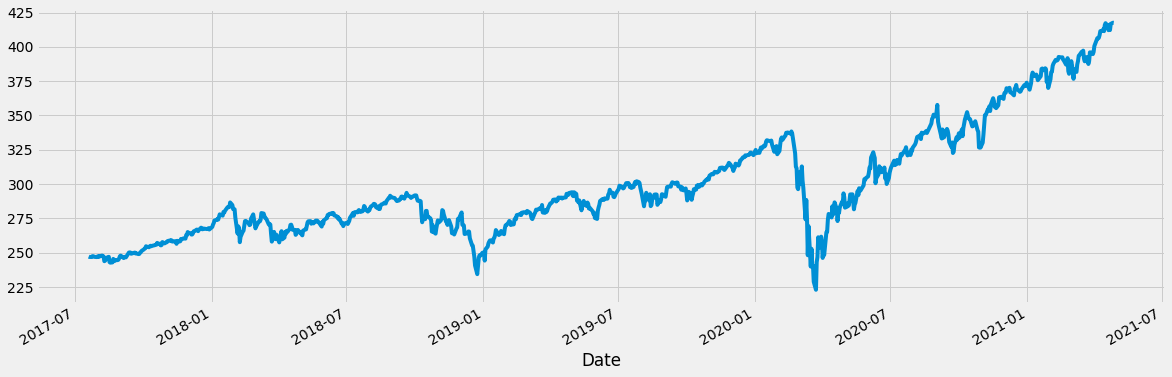

In [5]:
dataset.Close.plot(figsize=(18,6))

In [6]:
stoch = ta.momentum.stoch(dataset.High,dataset.Low,dataset.Close, window=14)

In [7]:
stoch.head(10)

Date
2017-07-20   NaN
2017-07-21   NaN
2017-07-24   NaN
2017-07-25   NaN
2017-07-26   NaN
2017-07-27   NaN
2017-07-28   NaN
2017-07-31   NaN
2017-08-01   NaN
2017-08-02   NaN
Name: stoch_k, dtype: float64

<AxesSubplot:xlabel='Date'>

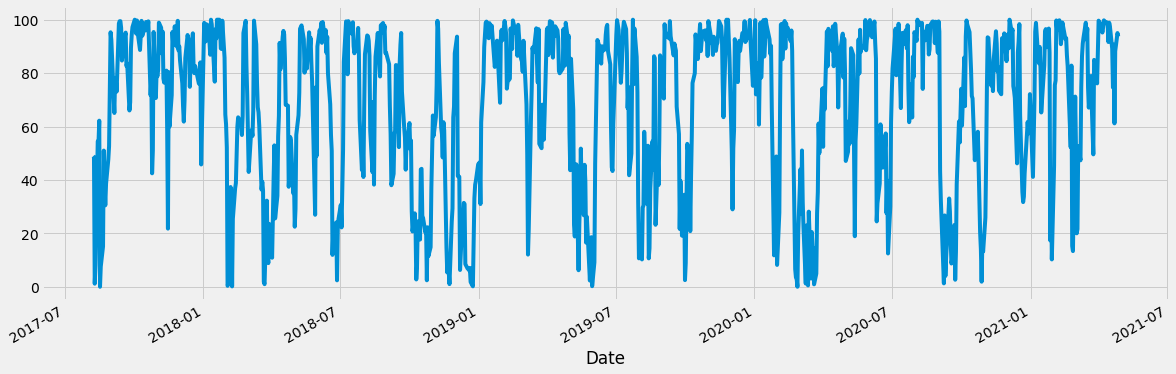

In [8]:
stoch.plot(figsize=(18,6))

<AxesSubplot:xlabel='Date'>

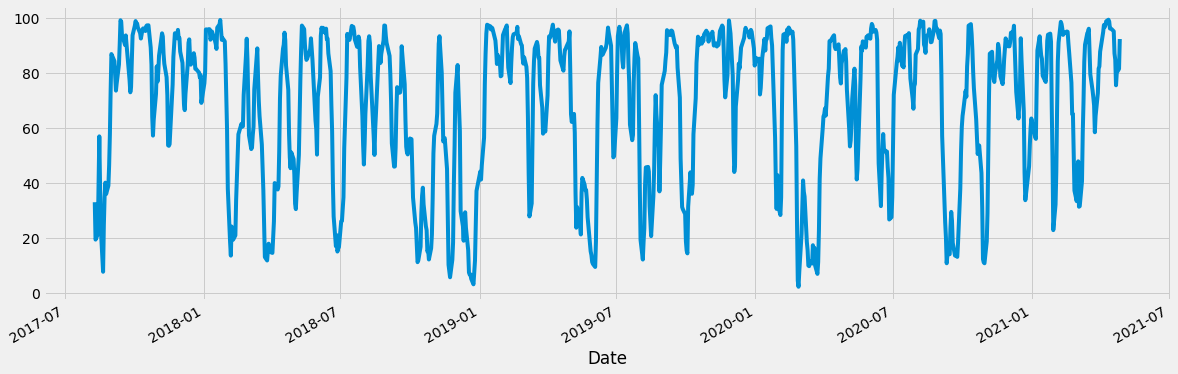

In [9]:
stoch_signal = ta.momentum.stoch_signal(dataset.High, dataset.Low, dataset.Close, window=14, smooth_window=3)
stoch_signal.plot(figsize=(18,6))

In [10]:
y = stoch_signal
x = np.arange(len(y))
dydx = np.append(np.ndarray([1]),np.diff(y)/np.diff(x))

df2 = pd.DataFrame({
    'close':dataset.Close,
    'stoch_signal': stoch_signal,
    'stoch_signal_DDX': dydx,
    'stoch' :stoch
})
df2.head(10)
#df2.plot(figsize=(16,6))

,close,stoch_signal,stoch_signal_DDX,stoch
Date,,,,
2017-07-20,247.100006,NaN,367.646856,NaN
2017-07-21,246.880005,NaN,NaN,NaN
2017-07-24,246.820007,NaN,NaN,NaN
2017-07-25,247.419998,NaN,NaN,NaN
2017-07-26,247.429993,NaN,NaN,NaN
2017-07-27,247.199997,NaN,NaN,NaN
2017-07-28,246.910004,NaN,NaN,NaN
2017-07-31,246.770004,NaN,NaN,NaN
2017-08-01,247.320007,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

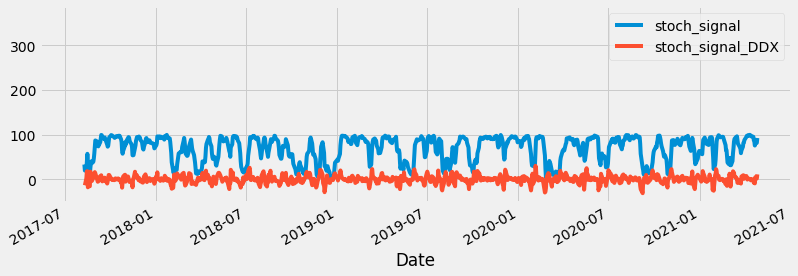

In [11]:
df2.drop(['close','stoch'],axis=1).plot(figsize=(12,4))

In [12]:
def stochStrat(df2=df2):

  moneyToInvest =10000
  shares =0
  for i in df2.index:
        
    close = df2.loc[i].at['close']
    stoch_signal = df2.loc[i].at['stoch_signal']
    stoch_signal_DDX = df2.loc[i].at['stoch_signal_DDX']  
    stoch = df2.loc[i].at['stoch']  

    if(stoch_signal_DDX > 0):
     #buy 
      numShares = math.floor((moneyToInvest)/close.round(2))
      shares+=numShares
      moneyToInvest -= (close.round(2) * numShares)
     
    elif(stoch_signal_DDX< 0):
       #sell
      #numShares = math.floor((moneyToInvest)/row.Close.round(2))
      moneyToInvest += (close.round(2) * shares)
      shares=0
    else:
      pass

    #moneyToInvest += 1000/20
    #end of innerloop 
    
 
  return int(df2.tail(1).close*shares+moneyToInvest)


stochStrat = stochStrat()

# f'{stochStrat:,}'  # For Python ≥3.7
print("result of no strat",f'{stochStrat:,}' )

increase= 100*round((stochStrat-resultOfNoStrat)/resultOfNoStrat,6)
print("\n\n   result of stochStrat: {}\n   result of no strat:   {}\n   Increase in preformance: {}%".format(stochStrat,resultOfNoStrat,increase))


result of no strat 12,686


   result of stochStrat: 12686
   result of no strat:   16817
   Increase in preformance: -24.5644%


In [13]:
def stochStrat2(df2=df2):

  moneyToInvest =10000
  shares =0
  for i in df2.index:
        
    close = df2.loc[i].at['close']
    stoch_signal = df2.loc[i].at['stoch_signal']
    stoch_signal_DDX = df2.loc[i].at['stoch_signal_DDX']  
    stoch = df2.loc[i].at['stoch']  

    if(stoch > stoch_signal):
     #buy 
      numShares = math.floor((moneyToInvest)/close.round(2))
      shares+=numShares
      moneyToInvest -= (close.round(2) * numShares)
     
    elif(stoch_signal< stoch):
       #sell
      #numShares = math.floor((moneyToInvest)/row.Close.round(2))
      moneyToInvest += (close.round(2) * shares)
      shares=0
    else:
      pass

    #moneyToInvest += 1000/20
    #end of innerloop 
    
 
  return int(df2.tail(1).close*shares+moneyToInvest)


stochStrat2 = stochStrat2()

# f'{stochStrat2:,}'  # For Python ≥3.7
print("result of no strat",f'{stochStrat2:,}' )

increase= 100*round((stochStrat2-resultOfNoStrat)/resultOfNoStrat,4)
print("\n\n   result of stochS2trat: {}\n   result of no strat:   {}\n   Increase in preformance: {}%".format(stochStrat2,resultOfNoStrat,increase))


result of no strat 16,840


   result of stochS2trat: 16840
   result of no strat:   16817
   Increase in preformance: 0.13999999999999999%


# Let's try VIXFix

In [14]:
vf = VIX_Fix(dataset.High,dataset.Low,dataset.Close,14)
vf_signal= VIX_Fix_signal(dataset.High,dataset.Low,dataset.Close,14)

In [15]:
y = vf_signal
x = np.arange(len(y))
dydx = np.append(np.ndarray([1]),np.diff(y)/np.diff(x))

df2 = pd.DataFrame({
    'close':dataset.Close,
     'vf' :vf,
    'vf_signal': vf_signal,
    'vf_signal_DDX': dydx
   
})
df2.head(10)
#df2.plot(figsize=(16,6))

,close,vf,vf_signal,vf_signal_DDX
Date,,,,
2017-07-20,247.100006,0.254630,0.254630,4.688683e-321
2017-07-21,246.880005,0.282925,0.268777,1.414747e-02
2017-07-24,246.820007,0.258675,0.265410,-3.367270e-03
2017-07-25,247.419998,0.500406,0.347335,8.192534e-02
2017-07-26,247.429993,0.504439,0.421173,7.383813e-02
2017-07-27,247.199997,0.612905,0.539250,1.180765e-01
2017-07-28,246.910004,0.495972,0.537772,-1.477863e-03
2017-07-31,246.770004,0.439521,0.516133,-2.163942e-02
2017-08-01,247.320007,0.661296,0.532263,1.613043e-02


<AxesSubplot:xlabel='Date'>

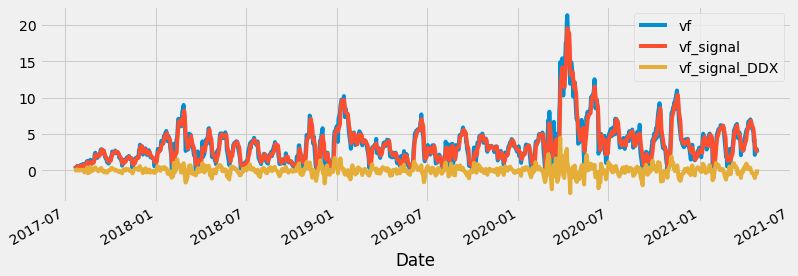

In [16]:
df2.drop(['close'],axis=1).plot(figsize=(12,4))

<AxesSubplot:xlabel='Date'>

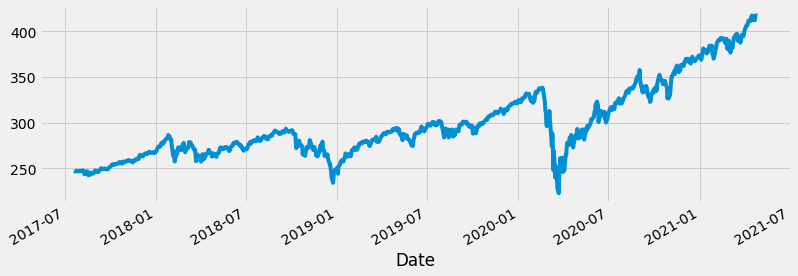

In [17]:
df2.close.plot(figsize=(12,4))

In [18]:
def VIXStrat(df2=df2):

  moneyToInvest =10000
  shares =0
  for i in df2.index:
        
    close = df2.loc[i].at['close']
    vf_signal = df2.loc[i].at['vf_signal']
    vf_signal_DDX = df2.loc[i].at['vf_signal_DDX']  
    vf = df2.loc[i].at['vf']  

    if(vf_signal_DDX > 0):
     #buy 
      numShares = math.floor((moneyToInvest)/close.round(2))
      shares+=numShares
      moneyToInvest -= (close.round(2) * numShares)
     
    elif(vf_signal_DDX< 0):
      #sell
      #numShares = math.floor((moneyToInvest)/row.Close.round(2))
      moneyToInvest += (close.round(2) * shares)
      shares=0
    else:
      pass

    #moneyToInvest += 1000/20
    #end of innerloop 
    
 
  return int(df2.tail(1).close*shares+moneyToInvest)


VIXStrat = VIXStrat()

# f'{VIXStrat:,}'  # For Python ≥3.7
print("result of no strat",f'{VIXStrat:,}' )

increase= 100*round((VIXStrat-resultOfNoStrat)/resultOfNoStrat,6)
print("\n\n   result of VIXStrat: {}\n   result of no strat:   {}\n   Increase in preformance: {}%".format(VIXStrat,resultOfNoStrat,increase))


result of no strat 13,474


   result of VIXStrat: 13474
   result of no strat:   16817
   Increase in preformance: -19.8787%


In [19]:
def VIXStrat2(df2=df2):

  moneyToInvest =10000
  shares =0
  for i in df2.index:
        
    close = df2.loc[i].at['close']
    vf_signal = df2.loc[i].at['vf_signal']
    vf_signal_DDX = df2.loc[i].at['vf_signal_DDX']  
    vf = df2.loc[i].at['vf']  

    if(vf > vf_signal):
     #buy 
      numShares = math.floor((moneyToInvest)/close.round(2))
      shares+=numShares
      moneyToInvest -= (close.round(2) * numShares)
     
    elif(vf < vf_signal):
      #sell
      #numShares = math.floor((moneyToInvest)/row.Close.round(2))
      moneyToInvest += (close.round(2) * shares)
      shares=0
    else:
      pass

    #moneyToInvest += 1000/20
    #end of innerloop 
    
 
  return int(df2.tail(1).close*shares+moneyToInvest)


VIXStrat2 = VIXStrat2()

# f'{VIXStrat2:,}'  # For Python ≥3.7
print("result of VIXStrat2",f'{VIXStrat2:,}' )

increase= 100 * round((VIXStrat2-resultOfNoStrat)/resultOfNoStrat, 6)
print("\n\n   result of VIXStrat2: {}\n   result of no strat:   {}\n   Increase in preformance: {}%".format(VIXStrat2, resultOfNoStrat, increase))

result of VIXStrat2 11,076


   result of VIXStrat2: 11076
   result of no strat:   16817
   Increase in preformance: -34.1381%
